> #  DataCamp

**Mohamed Niang**,**Hypolite Chokki**, **Fernanda Tchouacheu** & **Sokhna Penda Toure** 

**Pourquoi la détection de fraude ?**
> La fraude est un commerce d'un milliard de dollars et elle augmente chaque année. L'enquête mondiale de PwC sur la criminalité économique de 2018 a révélé que la moitié (49 %) des 7 200 entreprises interrogées avaient été victimes d'une fraude quelconque. C'est une augmentation par rapport à l'étude PwC de 2016, dans laquelle un peu plus d'un tiers des organisations interrogées (36 %) avaient été victimes de la criminalité économique.


Cette concurrence est un problème de **classification binaire** - c'est-à-dire que notre variable cible est un attribut binaire (l'utilisateur qui fait le clic est-il frauduleux ou non ?) et notre objectif est de classer les utilisateurs en "frauduleux" ou "non frauduleux" le mieux possible.

## Content

- Data exploration
- Missing Data
- Imbalanced problem


- Desciptive Statistics and Plots
    - Distribution and Count plots
    - Unique values
    - Groups
    
    
- Memory reduction  

- PCA


- First Models
    - XGBoost Model
    - LGBM

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)


import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os
os.chdir('/kaggle/input/ieeecis-fraud-detection') # Set working directory
print(os.listdir('/kaggle/input/ieeecis-fraud-detection'))

['sample_submission.csv', 'train_transaction.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv']


# Data Exploration

Dans cette compétition, nous voulons prédire la probabilité qu'une transaction en ligne soit frauduleuse, comme le montre la cible binaire "isFraud".

Les données sont divisées en deux fichiers **identity** et **transaction**, qui sont reliés par "TransactionID". 

> Note : Toutes les transactions n'ont pas d'informations d'identité correspondantes.

**Variables catégorielles - Transaction**

- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Variables catégorielles - Identité**

- DeviceType
- DeviceInfo
- id_12 - id_38

**La variable TransactionDT est un timedelta d'une date-heure de référence donnée (et non un horodatage réel).**

**Fichiers**

- train_{transaction, identité}.csv - l'ensemble d'apprentissage
- test_{transaction, identité}.csv - l'ensemble de test (**nous devons prédire la valeur isFraud pour ces observations**)
- sample_submission.csv - un exemple de fichier de soumission dans le format correct

> Questions

Nous allons commencer à explorer les données en se basant sur les caractéristiques catégorielles et les montants des transactions. L'objectif est de répondre à des questions comme :

1. Quel type de données avons-nous ?
2. Combien de cols, de lignes, de valeurs manquantes avons-nous ?
3. Quelle est la distribution cible ?
4. Quelle est la distribution des valeurs des transactions de fraude et des transactions sans fraude ?
5. Avons nous des produits frauduleux prédominants ?
6. Quelles sont les caractéristiques ou la cible qui présentent des schémas intéressants ?

Et beaucoup d'autres questions qui vont soulever l'exploration.

In [2]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def plot_distribution(df, var_select=None, title=None, bins=1.0): 
    # Calculate the correlation coefficient between the new variable and the target
    tmp_fraud = df[df['isFraud'] == 1]
    tmp_no_fraud = df[df['isFraud'] == 0]    
    corr = df['isFraud'].corr(df[var_select])
    corr = np.round(corr,3)
    tmp1 = tmp_fraud[var_select].dropna()
    tmp2 = tmp_no_fraud[var_select].dropna()
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Fraud', 'No Fraud']
    colors = ['seagreen','indianred', ]

    fig = ff.create_distplot(hist_data,
                             group_labels,
                             colors = colors, 
                             show_hist = True,
                             curve_type='kde', 
                             bin_size = bins
                            )
    
    fig['layout'].update(title = title+' '+'(corr target ='+ str(corr)+')')

    iplot(fig, filename = 'Density plot')
    
def plot_dist_churn(df, col, binary=None):
    tmp_churn = df[df[binary] == 1]
    tmp_no_churn = df[df[binary] == 0]
    tmp_attr = round(tmp_churn[col].value_counts().sort_index() / df[col].value_counts().sort_index(),2)*100
    print(f'Distribution of {col}: ')
    trace1 = go.Bar(
        x=tmp_churn[col].value_counts().sort_index().index,
        y=tmp_churn[col].value_counts().sort_index().values, 
        name='Fraud',opacity = 0.8, marker=dict(
            color='seagreen',
            line=dict(color='#000000',width=1)))

    trace2 = go.Bar(
        x=tmp_no_churn[col].value_counts().sort_index().index,
        y=tmp_no_churn[col].value_counts().sort_index().values,
        name='No Fraud', opacity = 0.8, 
        marker=dict(
            color='indianred',
            line=dict(color='#000000',
                      width=1)
        )
    )

    trace3 =  go.Scatter(   
        x=tmp_attr.sort_index().index,
        y=tmp_attr.sort_index().values,
        yaxis = 'y2', 
        name='% Fraud', opacity = 0.6, 
        marker=dict(
            color='black',
            line=dict(color='#000000',
                      width=2 )
        )
    )
    
    layout = dict(title =  f'Distribution of {str(col)} feature by %Fraud',
              xaxis=dict(type='category'), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [0, 15], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= 'Percentual Fraud Transactions'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    iplot(fig)

**Load data**

In [3]:
%%time
train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('test_identity.csv', index_col='TransactionID')
print ("Data is loaded!")

Data is loaded!
CPU times: user 46.2 s, sys: 3.54 s, total: 49.8 s
Wall time: 50.1 s


In [4]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 393)
test_transaction shape is (506691, 392)
train_identity shape is (144233, 40)
test_identity shape is (141907, 40)


In [5]:
train_transaction.head()

isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  ...  V330  V331  V332  V333  \
TransactionID                                    ...                           
2987000        150.0    discover  142.0  credit  ...   NaN   NaN   NaN   NaN   
2987001        150.0  mastercard  102.0  credit  ...   NaN   NaN   NaN   NaN   
2987002        150.0        visa  166.0   debit  ...   NaN   NaN   NaN   NaN   
2987003        150.0  mastercard  117.0   debit  ...   NaN   NaN   NaN   NaN   
2987004        150.0  mastercard  102.0  credit  ...   0.0   0.0   0.0   0.0   

              V334 V335  V336  V337  V338  V339  
TransactionID                                    
2987000        NaN  NaN   NaN   NaN   NaN   NaN  
2987001        NaN  NaN   NaN   NaN   NaN   NaN  
2987002        NaN  NaN   NaN   NaN   NaN   NaN  
2987003        NaN  NaN   NaN   NaN   NaN   NaN  
2987004        0.0  0.0   0.0   0.0   0.0   0.0  

[5 rows x 393 columns]

In [6]:
train_identity.head()

id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
TransactionID                                                              
2987004          0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
2987008         -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2987010         -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
2987011         -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
2987016          0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

               id_09  id_10  ...                id_31 id_32      id_33  \
TransactionID                ...                                         
2987004          NaN    NaN  ...  samsung browser 6.2  32.0  2220x1080   
2987008          NaN    NaN  ...   mobile safari 11.0  32.0   1334x750   
2987010          0.0    0.0  ...          chrome 62.0   NaN        NaN   
2987011          NaN    NaN  ...          chrome 62.0   NaN        NaN   
2987016          0.0    0.0  ...          chrome 62.0  24.0   1280x800   

                        id_34 id_35 id_36  id_37  id_38  DeviceType  \
TransactionID                                                         
2987004        match_status:2     T     F      T      T      mobile   
2987008        match_status:1     T     F      F      T      mobile   
2987010                   NaN     F     F      T      T     desktop   
2987011                   NaN     F     F      T      T     desktop   
2987016        match_status:2     T     F      T      T     desktop   

                                  DeviceInfo  
TransactionID                                 
2987004        SAMSUNG SM-G892A Build/NRD90M  
2987008                           iOS Device  
2987010                              Windows  
2987011                                  NaN  
2987016                                MacOS  

[5 rows x 40 columns]

# Missing Data

On remarque qu'il y a beaucoup de colonnes **NaN** : 

- ``` V300 ... V339``` 
- ``` id_01 ... id_34``` 

## 1er problème : NaN

**train_transaction**

In [7]:
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
card6             1571
dtype: int64
% of missing data =  41.17794374769424


**train_identity**

In [8]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_01         0
id_02      3361
id_03     77909
id_04     77909
id_05      7368
id_06      7368
id_07    139078
id_08    139078
id_09     69307
id_10     69307
dtype: int64
% of missing data =  36.47062392101669


In [9]:
del missing_values_count, total_cells, total_missing

# Imbalanced Problem

In [10]:
x = train_transaction['isFraud'].value_counts().index
y = train_transaction['isFraud'].value_counts().values

trace2 = go.Bar(
     x=x ,
     y=y,
     marker=dict(
         color=y,
         colorscale = 'Viridis',
         reversescale = True
     ),
     name="Imbalance",    
 )
layout = dict(
     title="Data imbalance - isFraud",
     #width = 900, height = 500,
     xaxis=go.layout.XAxis(
     automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
 #         domain=[0, 0.85],
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

## 2ème problème : Imbalanced

Nous remarquons que notre jeu de données ("isFraud") est déséquilibrée. La plupart des transactions sont non frauduleuses. Si nous utilisons ce cadre de données comme base pour nos modèles prédictifs et nos analyses, nous pourrions obtenir beaucoup d'erreurs et nos algorithmes seront probablement surdimensionnés puisqu'ils "supposeront" que la plupart des transactions ne sont pas des fraudes. Mais nous ne voulons pas que notre modèle suppose, nous voulons que notre modèle détecte des modèles qui donnent des signes de fraude !

**Déséquilibrée** signifie que le nombre de points de données disponibles pour les différentes classes est différent.

In [11]:
del x,y
gc.collect()

16004

# Desciptive Statistics and Plots

Dans cette partie, nous essayerons de voir, d'une part, ce que réprésente réellement certaines variables,
et d'autre part, s'il y a des liens entre les variables et la variable cible.

In [12]:
train_transaction['TransactionDT'].head()

TransactionID
2987000    86400
2987001    86401
2987002    86469
2987003    86499
2987004    86506
Name: TransactionDT, dtype: int64

In [13]:
train_transaction['TransactionDT'].shape[0] , train_transaction['TransactionDT'].nunique()

(590540, 573349)

In [14]:
train_transaction['TransactionDT'].value_counts().head(10)

9474817     8
11576951    5
7236588     5
4397066     5
8468062     4
8020359     4
7337054     4
5334992     4
1971839     4
1962054     4
Name: TransactionDT, dtype: int64

Nous allons utiliser la variable **transactionDT** pour mesurer le temps.

## Distribution and Count Plots[](http://)

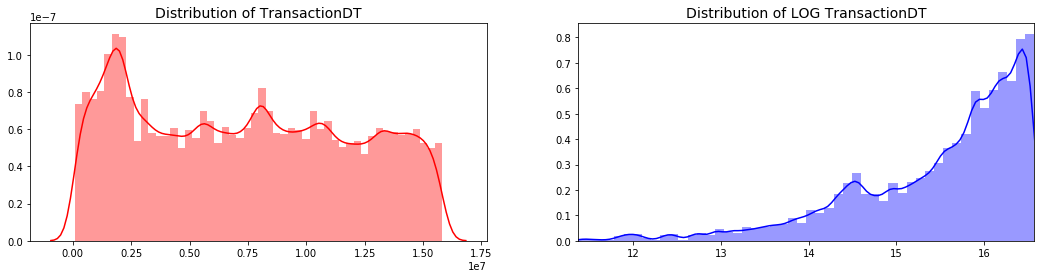

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

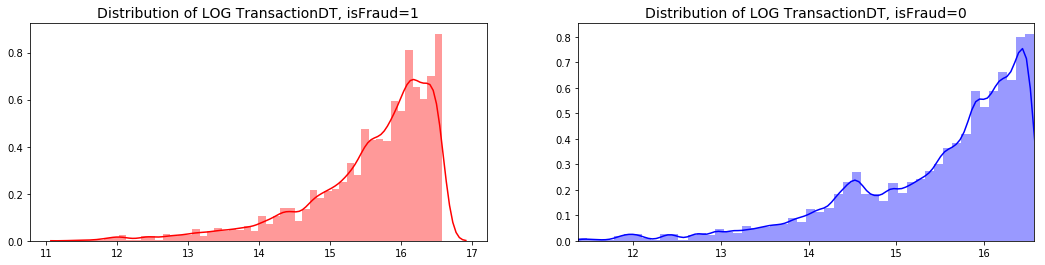

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionDT, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

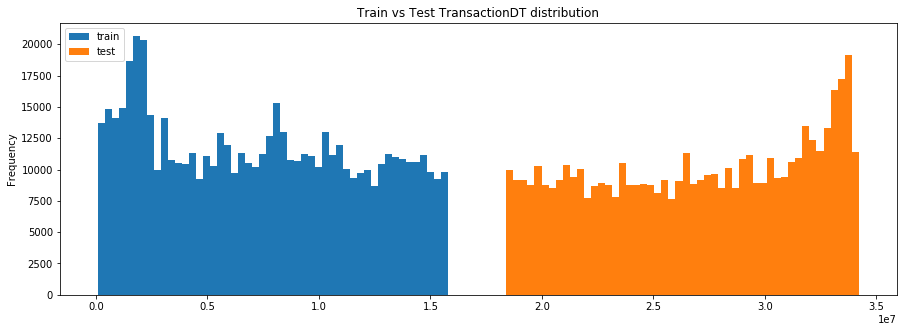

In [17]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

Comme nous pouvons le voir, il semble que les dates des transactions de train et de test ne se chevauchent pas, il serait donc prudent d'utiliser le fractionnement basé sur le temps pour la validation. 

In [18]:
train_transaction.head()

isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  ...  V330  V331  V332  V333  \
TransactionID                                    ...                           
2987000        150.0    discover  142.0  credit  ...   NaN   NaN   NaN   NaN   
2987001        150.0  mastercard  102.0  credit  ...   NaN   NaN   NaN   NaN   
2987002        150.0        visa  166.0   debit  ...   NaN   NaN   NaN   NaN   
2987003        150.0  mastercard  117.0   debit  ...   NaN   NaN   NaN   NaN   
2987004        150.0  mastercard  102.0  credit  ...   0.0   0.0   0.0   0.0   

              V334 V335  V336  V337  V338  V339  
TransactionID                                    
2987000        NaN  NaN   NaN   NaN   NaN   NaN  
2987001        NaN  NaN   NaN   NaN   NaN   NaN  
2987002        NaN  NaN   NaN   NaN   NaN   NaN  
2987003        NaN  NaN   NaN   NaN   NaN   NaN  
2987004        0.0  0.0   0.0   0.0   0.0   0.0  

[5 rows x 393 columns]

**isFraud vs time**

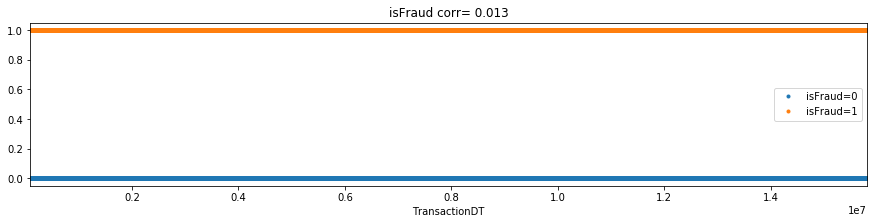

In [19]:
i = 'isFraud'
cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
train_transaction.loc[train_transaction['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
train_transaction.loc[train_transaction['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
plt.legend()
plt.show()

**C features: C1, C2 ... C14**

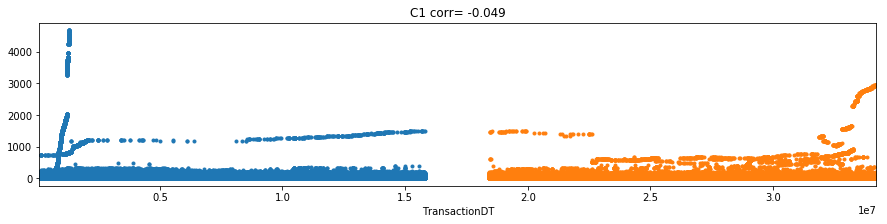

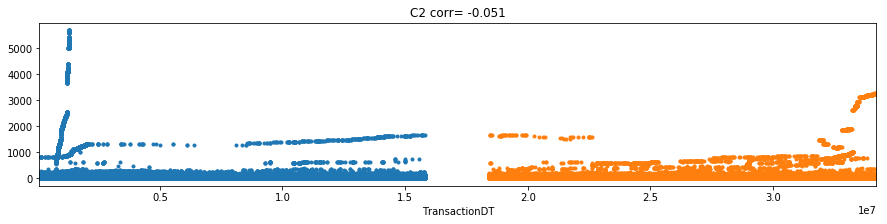

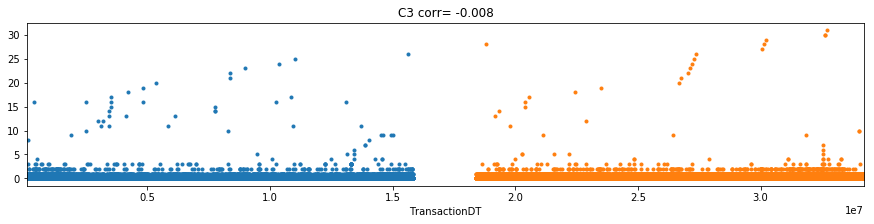

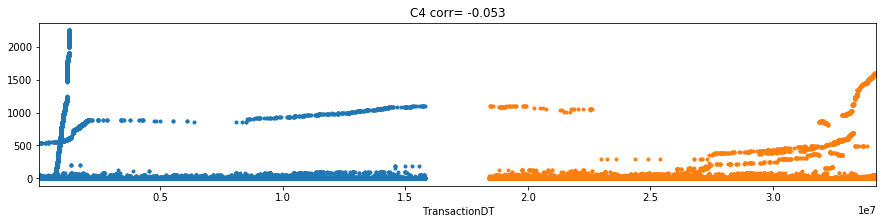

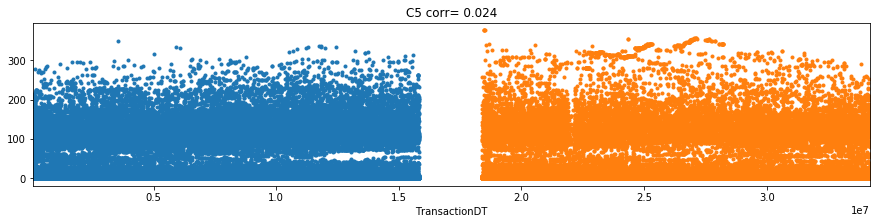

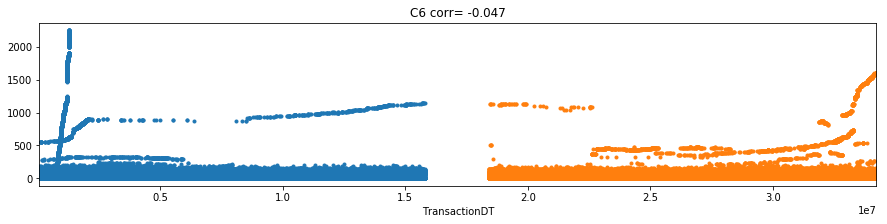

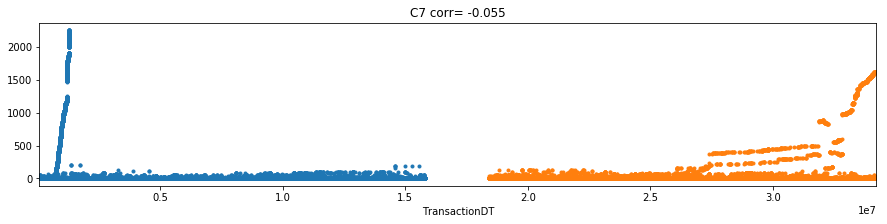

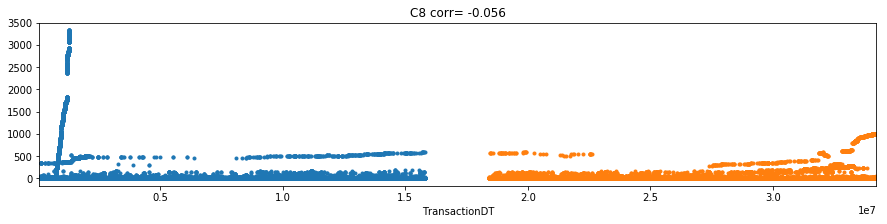

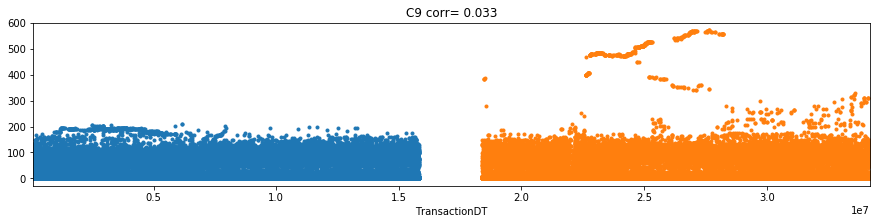

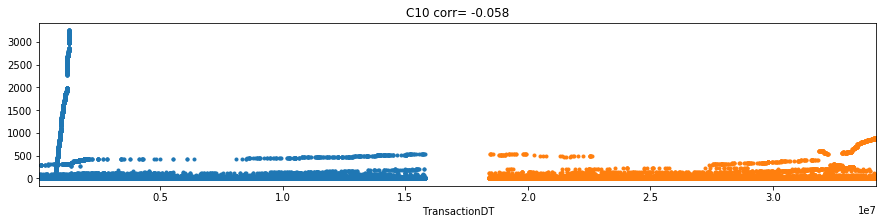

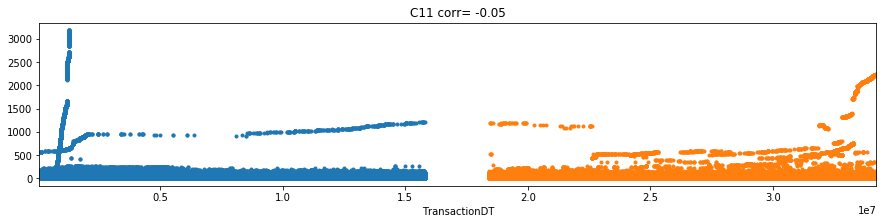

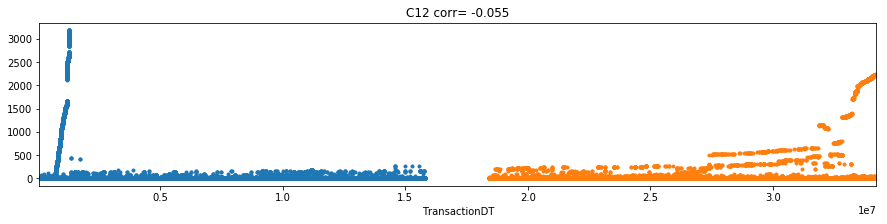

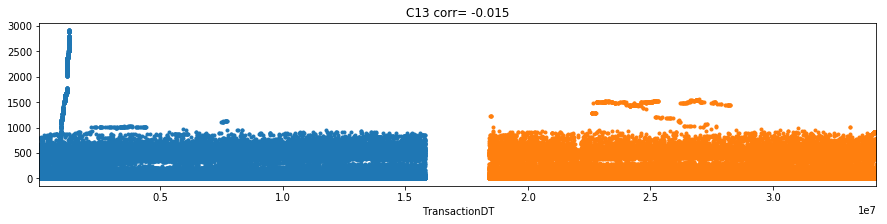

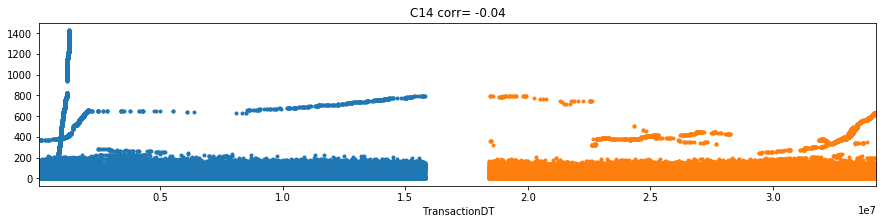

In [20]:
c_features = list(train_transaction.columns[16:30])
for i in c_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

In [21]:
del c_features
gc.collect()

52986

**D features: D1 ... D15**

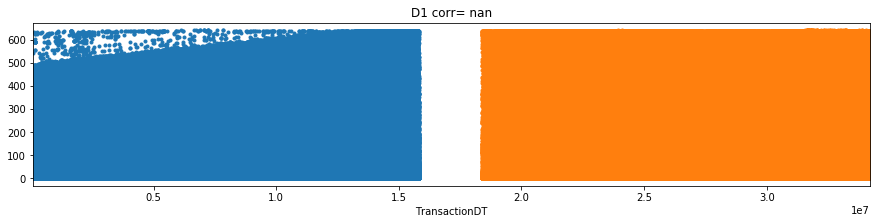

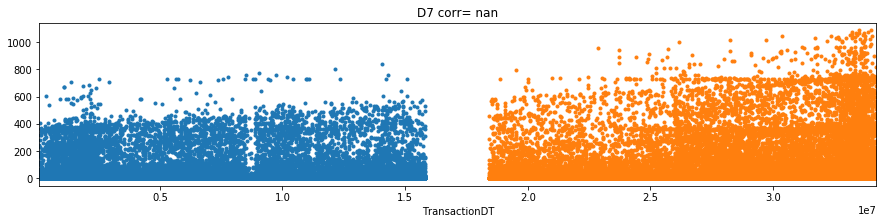

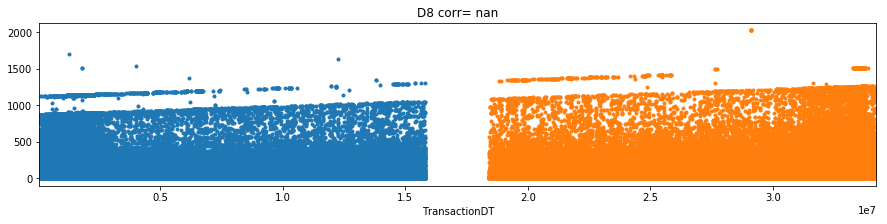

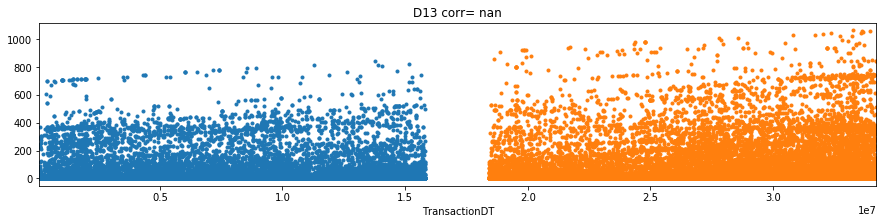

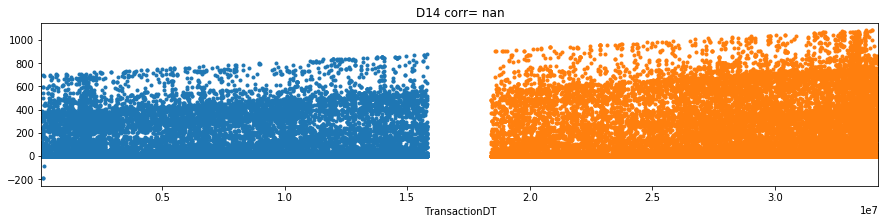

In [22]:
d_features = list(train_transaction.columns[30:45])

for i in d_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

Le problème ici est que les caractéristiques D sont principalement des NaNs.

In [23]:
train_transaction[d_features].head()

D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  \
TransactionID                                                               
2987000         14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0   
2987001          0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN   
2987002          0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0   
2987003        112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN  84.0    NaN   
2987004          0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   NaN    NaN   

               D12  D13  D14    D15  
TransactionID                        
2987000        NaN  NaN  NaN    0.0  
2987001        NaN  NaN  NaN    0.0  
2987002        NaN  NaN  NaN  315.0  
2987003        NaN  NaN  NaN  111.0  
2987004        NaN  NaN  NaN    NaN

In [24]:
# Click output to see the number of missing values in each column
missing_values_count = train_transaction[d_features].isnull().sum()
missing_values_count

D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64

In [25]:
# how many total missing values do we have?
total_cells = np.product(train_transaction[d_features].shape)
total_missing = missing_values_count.sum()
# percent of data that is missing
(total_missing/total_cells) * 100

58.15126268612908

Si nous considérons les caractéristiques D, 58.15% sont des valeurs manquantes.

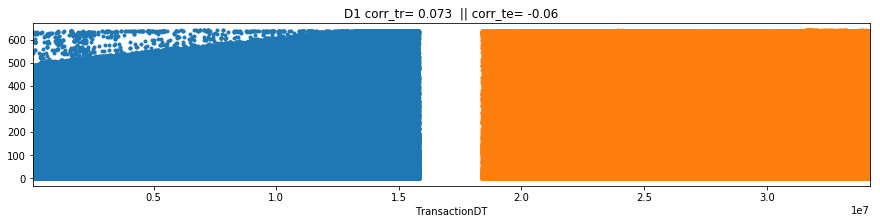

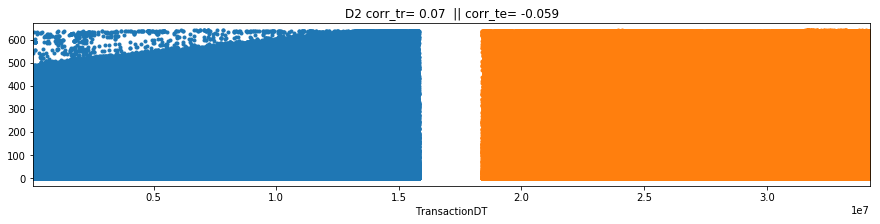

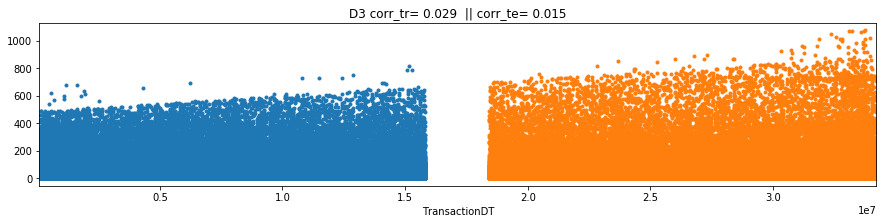

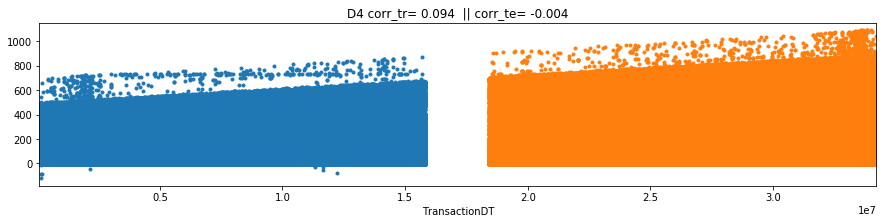

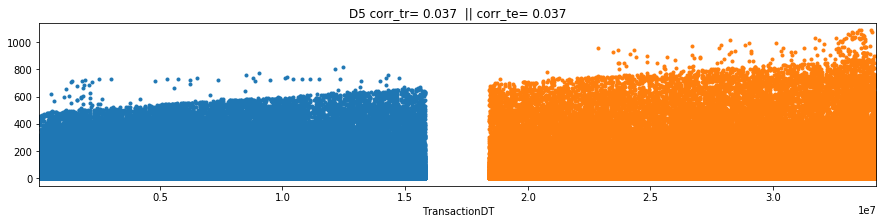

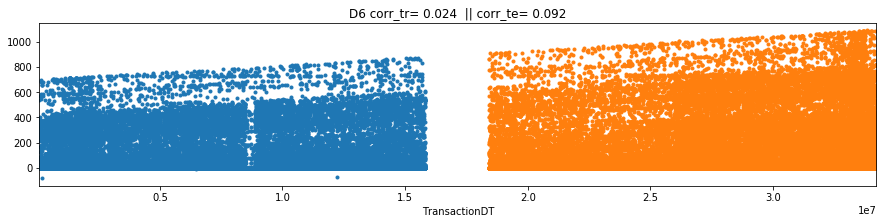

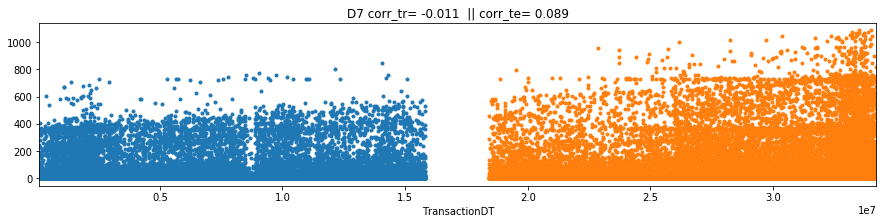

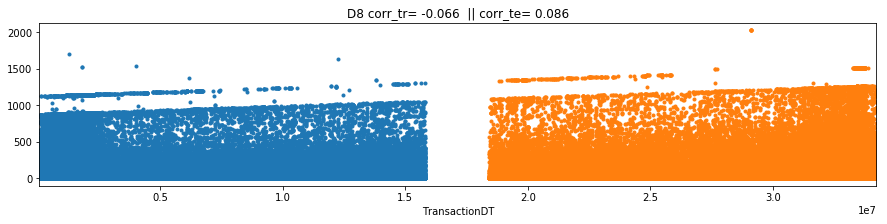

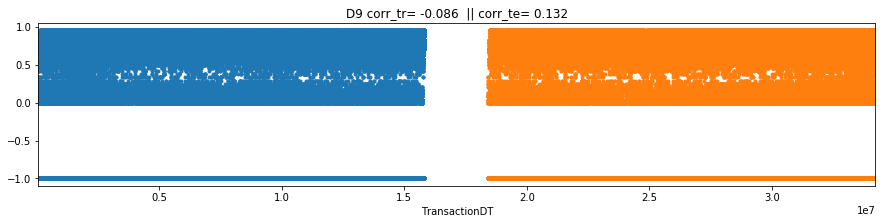

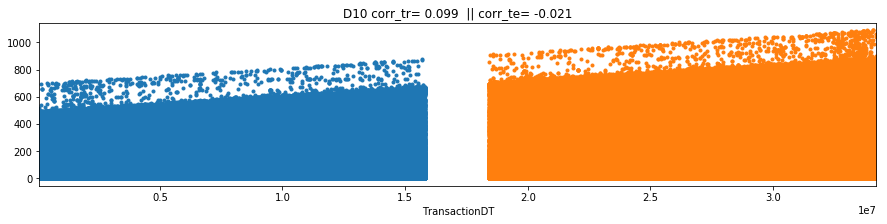

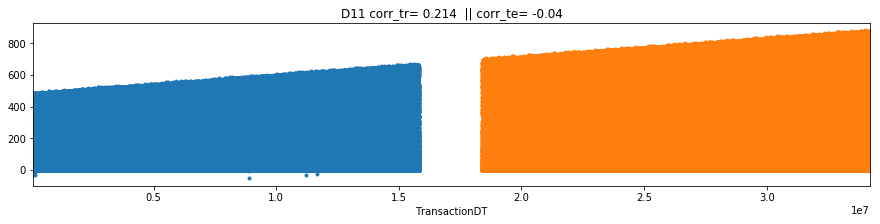

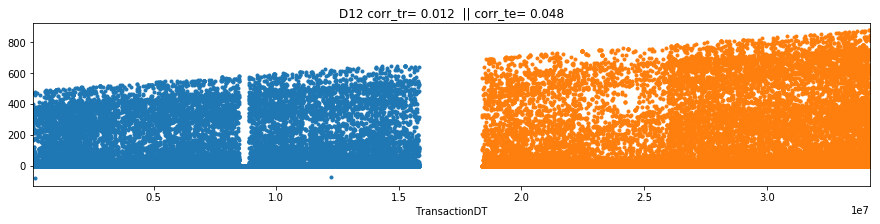

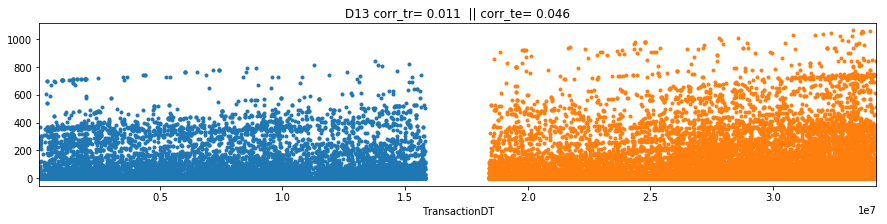

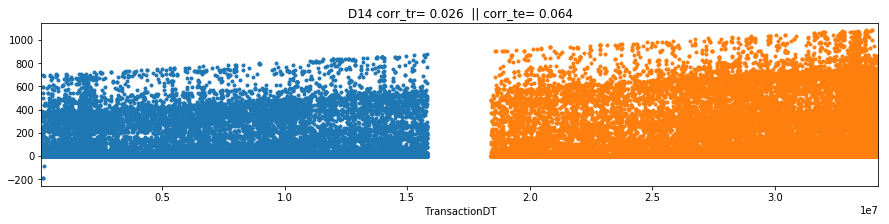

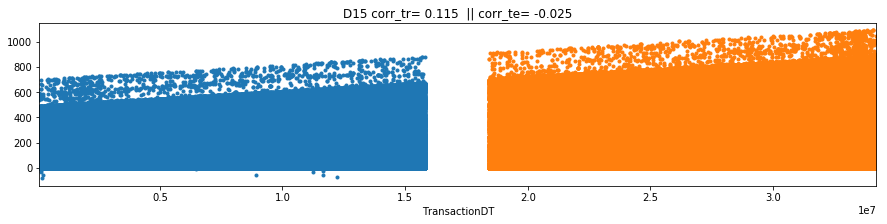

In [26]:
for i in d_features:
    cor_tr = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i].fillna(-1))[0,1]
    cor_te = np.corrcoef(test_transaction['TransactionDT'], test_transaction[i].fillna(-1))[0,1]
    train_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+" || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+"  || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
    plt.show()

In [27]:
del d_features, cor
gc.collect()

69431

**M features: M1 .. M9**

In [29]:
m_features = list(train_transaction.columns[45:54])
train_transaction[m_features].head()

M1   M2   M3   M4   M5   M6   M7   M8   M9
TransactionID                                             
2987000          T    T    T   M2    F    T  NaN  NaN  NaN
2987001        NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2987002          T    T    T   M0    F    F    F    F    F
2987003        NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
2987004        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [30]:
del m_features
gc.collect()

0

**V150**

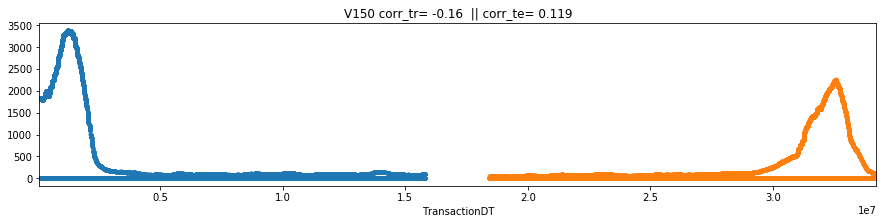

In [31]:
i = "V150"
cor_tr = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i].fillna(-1))[0,1]
cor_te = np.corrcoef(test_transaction['TransactionDT'], test_transaction[i].fillna(-1))[0,1]
train_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+" || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
test_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+"  || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
plt.show()

Vérifions toute la liste des V qui sont nulles.

In [32]:
train_transaction.loc[:,train_transaction.columns[train_transaction.columns.str.startswith('V')]].isnull().sum()

V1      279287
V2      279287
V3      279287
V4      279287
V5      279287
         ...  
V335    508189
V336    508189
V337    508189
V338    508189
V339    508189
Length: 339, dtype: int64

**TransactionAmt**

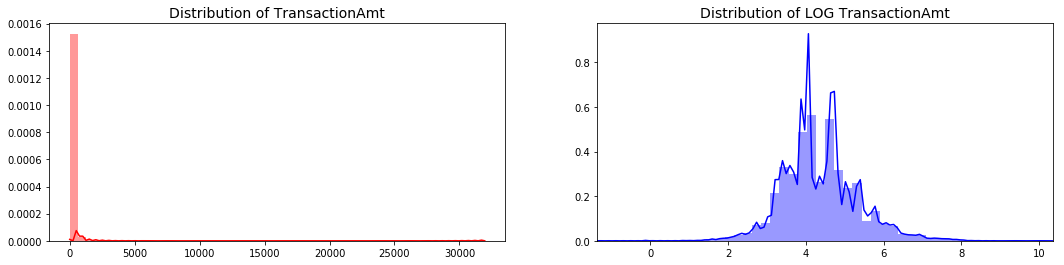

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

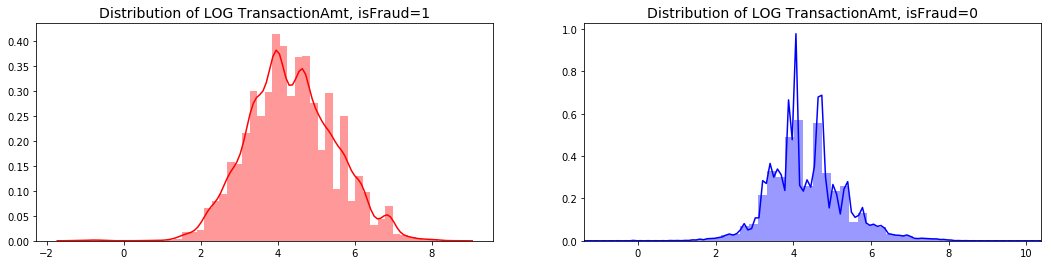

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionAmt, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

In [35]:
del time_val

In [36]:
tmp = train_transaction[['TransactionAmt', 'isFraud']][0:100000]
plot_distribution(tmp[(tmp['TransactionAmt'] <= 800)], 'TransactionAmt', 'Transaction Amount Distribution', bins=10.0,)
del tmp

## Unique Values

**D Features**

In [ ]:
plt.figure(figsize=(10, 7))
d_features = list(train_transaction.columns[30:45])
uniques = [len(train_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 